# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive/

In [ ]:
import os

In [ ]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [ ]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [ ]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 74196, done.
remote: Counting objects: 100% (282/282), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 74196 (delta 130), reused 262 (delta 118), pack-reused 73914
Receiving objects: 100% (74196/74196), 580.25 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (52565/52565), done.


In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/bin/bash: line 0: cd: Tensorflow/models/research: No such file or directory


# Load Checkpoint

In [ ]:
import object_detection

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
# Unzip models from drive to env
arcive_models = '/mydrive/TFOD/models.tar.gz'
!tar -zxvf {arcive_models}

Tensorflow/workspace/models/my_ssd_mobnet/
Tensorflow/workspace/models/my_ssd_mobnet/ckpt-1.index
Tensorflow/workspace/models/my_ssd_mobnet/ckpt-1.data-00000-of-00001
Tensorflow/workspace/models/my_ssd_mobnet/train/
Tensorflow/workspace/models/my_ssd_mobnet/train/events.out.tfevents.1653556328.842d1caed888.420.0.v2
Tensorflow/workspace/models/my_ssd_mobnet/eval/
Tensorflow/workspace/models/my_ssd_mobnet/eval/events.out.tfevents.1653556631.842d1caed888.723.0.v2
Tensorflow/workspace/models/my_ssd_mobnet/ckpt-2.data-00000-of-00001
Tensorflow/workspace/models/my_ssd_mobnet/ckpt-3.index
Tensorflow/workspace/models/my_ssd_mobnet/export/
Tensorflow/workspace/models/my_ssd_mobnet/export/pipeline.config
Tensorflow/workspace/models/my_ssd_mobnet/export/saved_model/
Tensorflow/workspace/models/my_ssd_mobnet/export/saved_model/variables/
Tensorflow/workspace/models/my_ssd_mobnet/export/saved_model/variables/variables.data-00000-of-00001
Tensorflow/workspace/models/my_ssd_mobnet/export/saved_model/

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.64

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [ ]:
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.4 MB/s 


In [ ]:
# copy label_map models from drive to env

!cp -r /content/gdrive/MyDrive/TFOD/KAYECE-3 /content/Tensorflow/workspace/annotations

In [ ]:
!unzip test.zip

unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.


In [ ]:
!unzip test_kartu.zip

Archive:  test_kartu.zip
   creating: test_kartu/
 extracting: test_kartu/1.jpg        
 extracting: test_kartu/2.jpg        
  inflating: test_kartu/4.jpg        
  inflating: test_kartu/5.jpg        
  inflating: test_kartu/6.jpg        


In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [ ]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'car.jpeg')

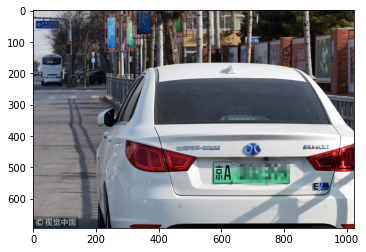

In [ ]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Detect Realtime-Video

In [ ]:
cap = cv2.VideoCapture(-1)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    # cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# Inference TFLite Testing

In [ ]:
# Import packages
import os
import argparse
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import sys
import glob
import importlib.util

In [ ]:
MODEL_NAME = '/content/Tensorflow/workspace/models/my_ssd_mobnet/tfliteexport/'
GRAPH_NAME = '/content/Tensorflow/workspace/models/my_ssd_mobnet/tfliteexport/detect__with_metadata.tflite'
LABELMAP_NAME = '/content/Tensorflow/workspace/models/my_ssd_mobnet/tfliteexport/labelmap.txt'
min_conf_threshold = 0.5

# Get path to current working directory
CWD_PATH = os.getcwd()

# Import TensorFlow libraries
# If tflite_runtime is installed, import interpreter from tflite_runtime, else import from regular tensorflow
# If using Coral Edge TPU, import the load_delegate library
pkg = importlib.util.find_spec('tflite_runtime')
if pkg:
    from tflite_runtime.interpreter import Interpreter
    if False:
        from tflite_runtime.interpreter import load_delegate
else:
    from tensorflow.lite.python.interpreter import Interpreter
    if False:
        from tensorflow.lite.python.interpreter import load_delegate

# If using Edge TPU, assign filename for Edge TPU model
if True:
    # If user has specified the name of the .tflite file, use that name, otherwise use default 'edgetpu.tflite'
    GRAPH_NAME == 'detect__with_metadata.tflite'

# Path to .tflite file, which contains the model that is used for object detection
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,GRAPH_NAME)

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,MODEL_NAME,LABELMAP_NAME)

# Load the label map
with open(PATH_TO_LABELS, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

# Have to do a weird fix for label map if using the COCO "starter model" from
# https://www.tensorflow.org/lite/models/object_detection/overview
# First label is '???', which has to be removed.
if labels[0] == '???':
    del(labels[0])

# Load the Tensorflow Lite model.
# If using Edge TPU, use special load_delegate argument
if True:
  interpreter = Interpreter(model_path=PATH_TO_CKPT)

interpreter.allocate_tensors()


In [ ]:
print(GRAPH_NAME)

/content/Tensorflow/workspace/models/my_ssd_mobnet/tfliteexport/detect__with_metadata.tflite


In [ ]:
# Parse input image name and directory. 
IM_NAME = '/content/Tensorflow/workspace/images/test/ktp3.jpg'
IM_DIR = '/content/Tensorflow/workspace/images/test'

In [ ]:
# Define path to images and grab all image filenames
if IM_DIR:
    PATH_TO_IMAGES = os.path.join(CWD_PATH,IM_DIR)
    print(PATH_TO_IMAGES)
    images = glob.glob(PATH_TO_IMAGES + '/*')
    print(images)

elif IM_NAME:
    PATH_TO_IMAGES = os.path.join(CWD_PATH,IM_NAME)
    print(PATH_TO_IMAGES)
    images = glob.glob(PATH_TO_IMAGES)
    print(images)

/content/Tensorflow/workspace/images/test
['/content/Tensorflow/workspace/images/test/ktp.jpg', '/content/Tensorflow/workspace/images/test/kartu2.jpg', '/content/Tensorflow/workspace/images/test/kartu5.jpg', '/content/Tensorflow/workspace/images/test/sim1.jpg', '/content/Tensorflow/workspace/images/test/ktp3.jpg', '/content/Tensorflow/workspace/images/test/ktp2.jpg', '/content/Tensorflow/workspace/images/test/kartu1.jpg', '/content/Tensorflow/workspace/images/test/kartu4.jpg', '/content/Tensorflow/workspace/images/test/kartu3.jpg', '/content/Tensorflow/workspace/images/test/sim2.jpg', '/content/Tensorflow/workspace/images/test/car2.jpeg', '/content/Tensorflow/workspace/images/test/ktp4.jpg']


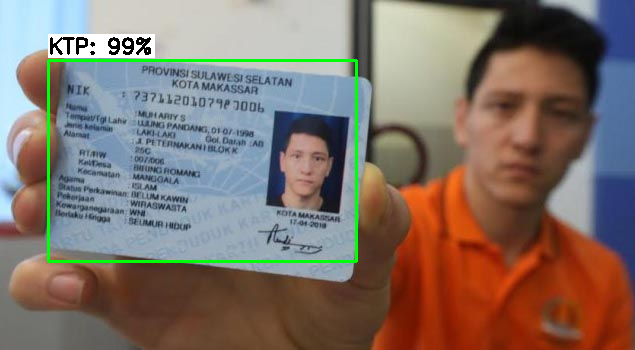

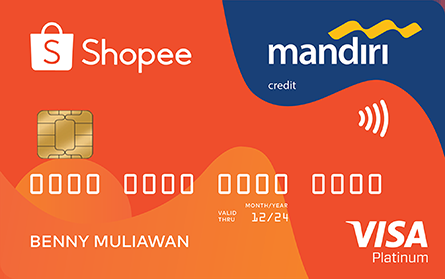

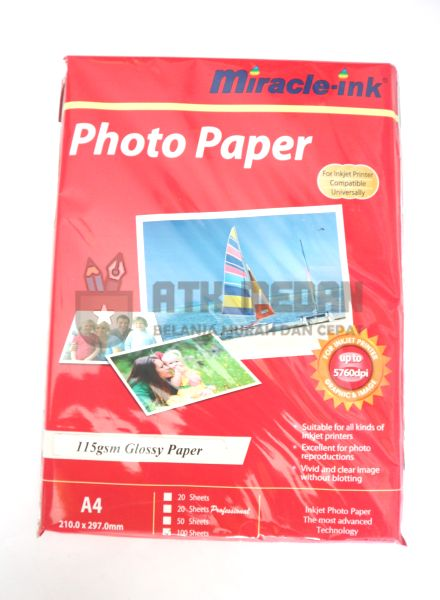

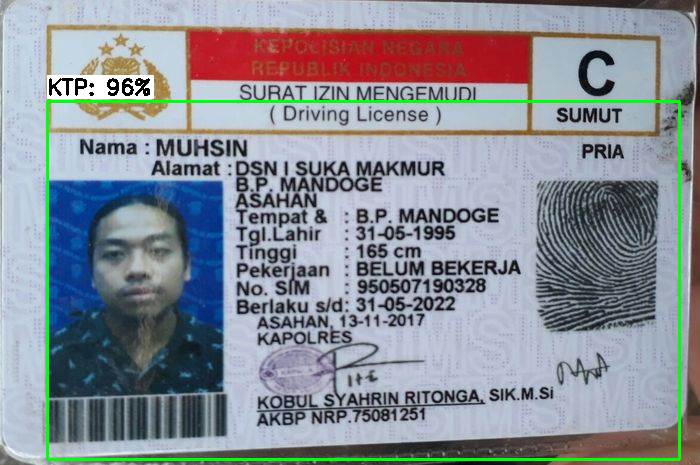

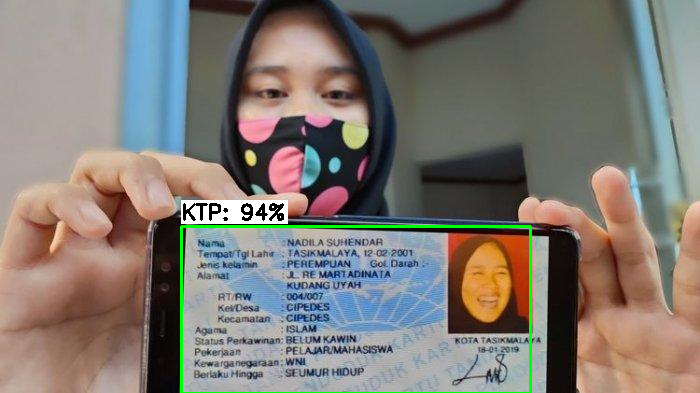

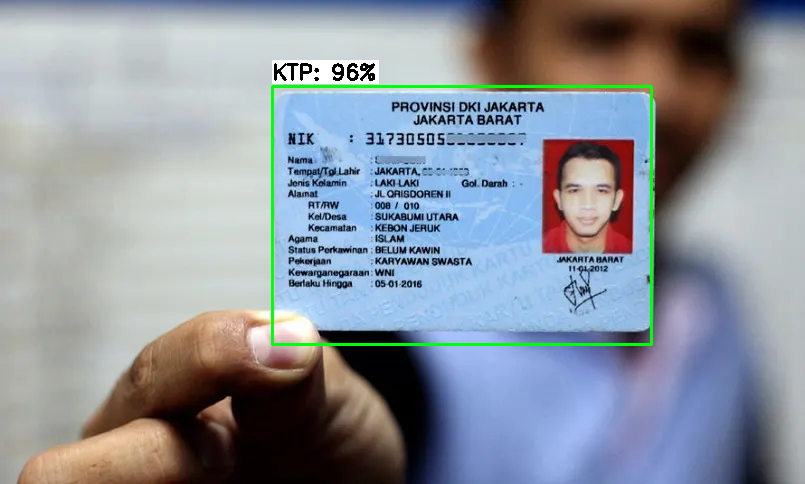

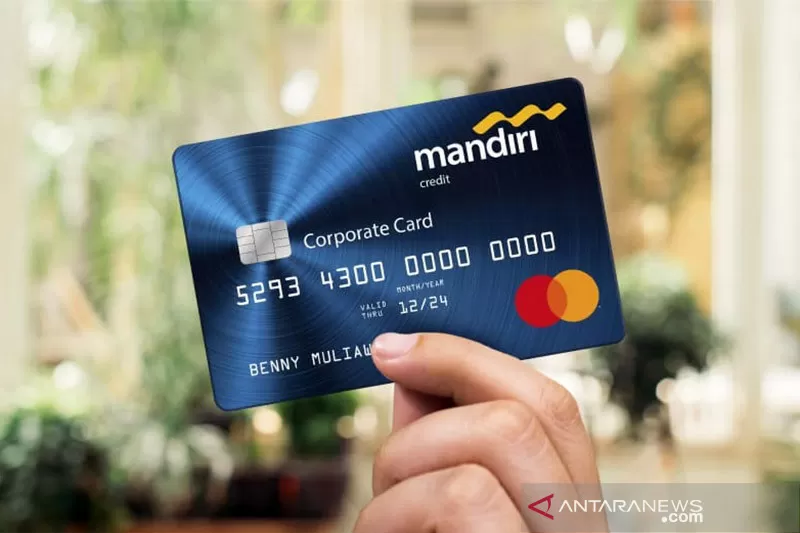

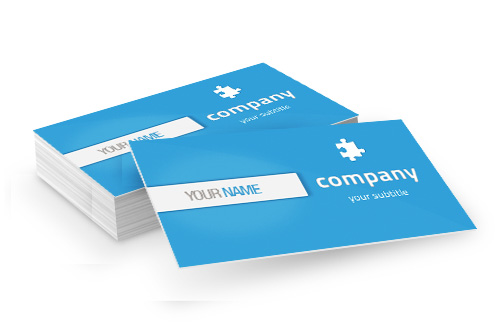

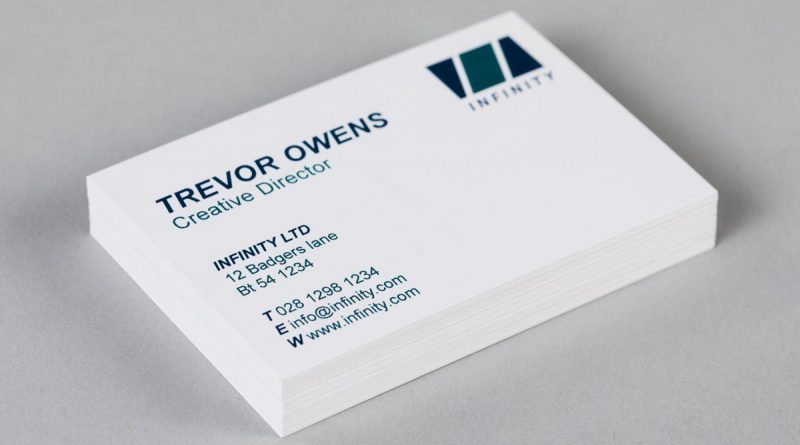

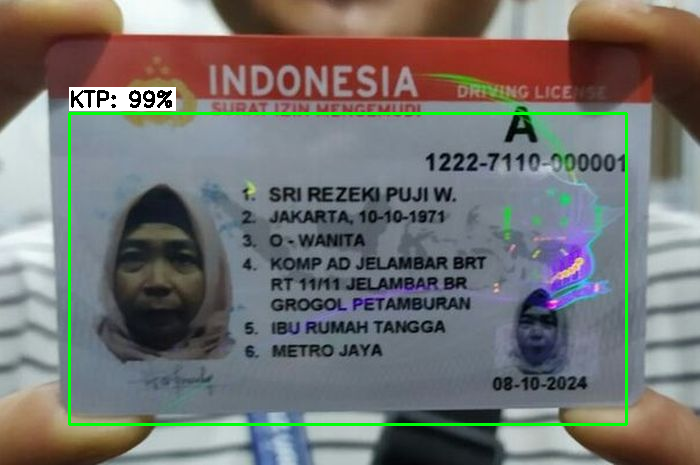

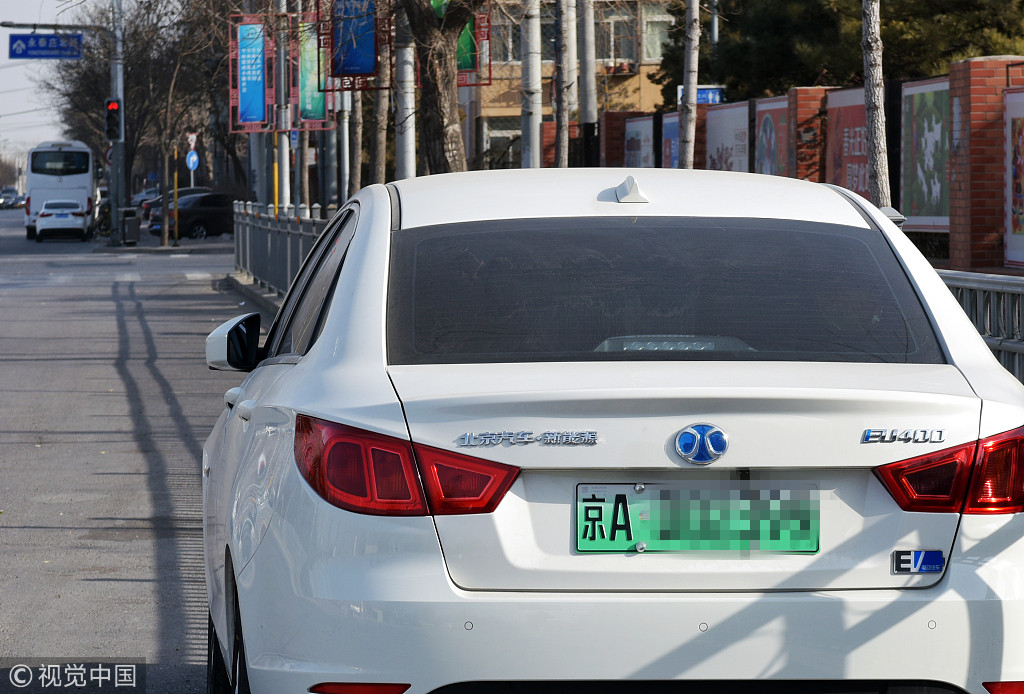

In [ ]:
# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

floating_model = (input_details[0]['dtype'] == np.float32)

input_mean = 127.5
input_std = 127.5

# Check output layer name to determine if this model was created with TF2 or TF1,
# because outputs are ordered differently for TF2 and TF1 models
outname = output_details[0]['name']

if ('StatefulPartitionedCall' in outname): # This is a TF2 model
    boxes_idx, classes_idx, scores_idx = 1, 3, 0
else: # This is a TF1 model
    boxes_idx, classes_idx, scores_idx = 0, 1, 2

# Loop over every image and perform detection
for image_path in images:

    # Load image and resize to expected shape [1xHxWx3]
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imH, imW, _ = image.shape 
    image_resized = cv2.resize(image_rgb, (width, height))
    input_data = np.expand_dims(image_resized, axis=0)

    # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
    if floating_model:
        input_data = (np.float32(input_data) - input_mean) / input_std

    # Perform the actual detection by running the model with the image as input
    interpreter.set_tensor(input_details[0]['index'],input_data)
    interpreter.invoke()

    # Retrieve detection results
    boxes = interpreter.get_tensor(output_details[boxes_idx]['index'])[0] # Bounding box coordinates of detected objects
    classes = interpreter.get_tensor(output_details[classes_idx]['index'])[0] # Class index of detected objects
    scores = interpreter.get_tensor(output_details[scores_idx]['index'])[0] # Confidence of detected objects

    # Loop over all detections and draw detection box if confidence is above minimum threshold
    for i in range(len(scores)):
        if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):

            # Get bounding box coordinates and draw box
            # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
            ymin = int(max(1,(boxes[i][0] * imH)))
            xmin = int(max(1,(boxes[i][1] * imW)))
            ymax = int(min(imH,(boxes[i][2] * imH)))
            xmax = int(min(imW,(boxes[i][3] * imW)))
            
            cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

            # Draw label
            object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
            label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
            label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
            cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
            cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

    # All the results have been drawn on the image, now display the image
    cv2_imshow(image)


# Pre-processing Image Before OCR

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract

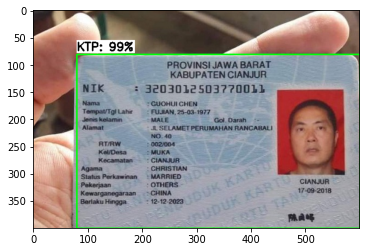

In [ ]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
!pip install craft-text-detector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from craft_text_detector import Craft

In [ ]:
# set image path and export folder directory
# image = 'figures/idcard.png' # can be filepath, PIL image or numpy array
output_dir = 'outputs/'

# create a craft instance
craft = Craft(output_dir=output_dir, crop_type="poly", cuda=False)

# apply craft text detection and export detected regions to output directory
prediction_result = craft.detect_text(image)

# unload models from ram/gpu
craft.unload_craftnet_model()
craft.unload_refinenet_model()

Craft text detector weight will be downloaded to /root/.craft_text_detector/weights/craft_mlt_25k.pth


Downloading...
From: https://drive.google.com/uc?id=1bupFXqT-VU6Jjeul13XP7yx2Sg5IHr4J
To: /root/.craft_text_detector/weights/craft_mlt_25k.pth
100%|██████████| 83.2M/83.2M [00:00<00:00, 221MB/s]


Craft text refiner weight will be downloaded to /root/.craft_text_detector/weights/craft_refiner_CTW1500.pth


Downloading...
From: https://drive.google.com/uc?id=1xcE9qpJXp4ofINwXWVhhQIh9S8Z7cuGj
To: /root/.craft_text_detector/weights/craft_refiner_CTW1500.pth
100%|██████████| 1.85M/1.85M [00:00<00:00, 56.0MB/s]
/usr/local/lib/python3.7/dist-packages/craft_text_detector/craft_utils.py:415: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys = np.array(polys)
/usr/local/lib/python3.7/dist-packages/craft_text_detector/predict.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys_as_ratio = np.array(polys_as_ratio)


In [ ]:
imgs = cv2.imread('/content/outputs/image_text_detection.png')

In [ ]:
gray = cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)

## (2) Threshold
th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)

## (3) Detect
result = pytesseract.image_to_string((threshed), lang="ind")

final = []

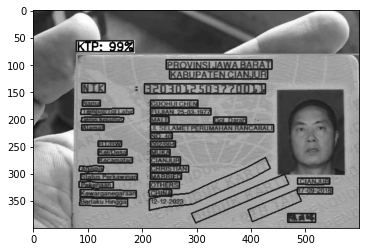

In [ ]:
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

In [ ]:
print(result)

       
     

TOR

ken Kena
ME AM PENUAAN MANCABALI



In [ ]:
print(boxes)

[[ 0.20375994  0.13362584  1.0037858   1.0155026 ]
 [ 0.3713662   0.15132242  1.0923083   0.80558264]
 [ 0.67220145  0.15705508  0.9829683   0.9262988 ]
 [-0.18619338  0.03375113  1.0198779   1.0338546 ]
 [ 0.21942914  0.41956684  0.9247526   1.0276909 ]
 [-0.04659003  0.73911256  0.34422702  1.1415339 ]
 [-0.79491276 -0.5076113   0.9502569   1.2390478 ]
 [-0.13846132  0.7343774   0.25179768  1.1544784 ]
 [ 0.53450793  0.19875944  0.89664525  0.92700005]
 [ 0.74525     0.13723984  1.0819118   0.9335638 ]]


In [ ]:
print(classes)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print(scores)

[0.9955384  0.07503836 0.06875622 0.05637885 0.04723027 0.04718322
 0.04307898 0.03943078 0.03607833 0.03578298]


# OCR

In [ ]:
!sudo apt install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-ind tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,330 kB of archives.
After this operation, 16.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Get:4 http://archive.ubuntu.

In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 9.5 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import cv2
import json
import re


In [ ]:
detection_threshold = 0.7

In [ ]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [ ]:
print(boxes)

[[ 0.20375994  0.13362584  1.0037858   1.0155026 ]
 [ 0.3713662   0.15132242  1.0923083   0.80558264]
 [ 0.67220145  0.15705508  0.9829683   0.9262988 ]
 [-0.18619338  0.03375113  1.0198779   1.0338546 ]
 [ 0.21942914  0.41956684  0.9247526   1.0276909 ]
 [-0.04659003  0.73911256  0.34422702  1.1415339 ]
 [-0.79491276 -0.5076113   0.9502569   1.2390478 ]
 [-0.13846132  0.7343774   0.25179768  1.1544784 ]
 [ 0.53450793  0.19875944  0.89664525  0.92700005]
 [ 0.74525     0.13723984  1.0819118   0.9335638 ]]


In [ ]:
width = image.shape[1]
height = image.shape[0]

In [ ]:
from pytesseract import Output

['', '', '', '', '']


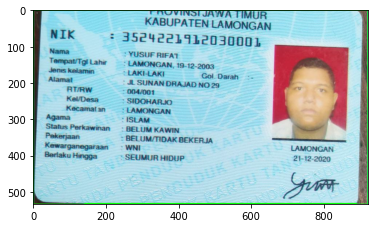

In [ ]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    # print(box)
    roi = box*[height, width, height, width]
    # print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
    # th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)
    ocr_result = pytesseract.image_to_string((gray), lang="ind")
    det_box = pytesseract.image_to_data(region, output_type=Output.DICT)
    print(det_box['text'])
    n_boxes = len(det_box['text'])
    for i in range(n_boxes):
      if int(det_box['conf'][i]) > 60:
        (x, y, w, h) = (det_box['left'][i], det_box['top'][i], det_box['width'][i], det_box['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    

    # print(ocr_result)
    # plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [ ]:
final = []

  ## (5) Normalize
for word in ocr_result.split("\n"):
      if "”—" in word:
          word = word.replace("”—", ":")
      
      #normalize NIK
      if "NIK" in word:
          nik_char = word.split()
        #if "D" in word:
        #    word = word.replace("D", "0")
      if "?" in word:
          word = word.replace("?", "7") 
      
      final.append(word)

In [ ]:
print(final)

[' ', '', 'Nama', 'Tempat Tg/ Lah: FASIKMALAYA, 12:02:2001', 'Siketamn PEREMPUAN ” Got Daran', 'Manar 1 REMARTADINATA', 'KUDANG UYAH', '', 'Raw 00emo7', '', 'KelDesa —CIPEDES', '', 'Kecamatan - CIPEDES', 'Koma ISLAM', 'Situs Perkawinan BELUM KAWIN', 'Pekerjaan PELAAPUMAHASSWA', 'Kewa!ganegaraan: WNI', 'Beriaku Hingga — SEUMUR HIDUP', '', ' ', '', '3', '\x0c']


In [ ]:
def to_json(self):
  return json.dumps(self.result.__dict__, indent=4)

In [ ]:
json.dumps(final)

'[" ", "", "Nama", "Tempat Tg/ Lah: FASIKMALAYA, 12:02:2001", "Siketamn PEREMPUAN \\u201d Got Daran", "Manar 1 REMARTADINATA", "KUDANG UYAH", "", "Raw 00emo7", "", "KelDesa \\u2014CIPEDES", "", "Kecamatan - CIPEDES", "Koma ISLAM", "Situs Perkawinan BELUM KAWIN", "Pekerjaan PELAAPUMAHASSWA", "Kewa!ganegaraan: WNI", "Beriaku Hingga \\u2014 SEUMUR HIDUP", "", " ", "", "3", "\\f"]'